# Imports

In [1]:
import numpy as np
import os
import sys
import pickle
from functools import reduce
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, IntSlider
from scipy import stats
import scipy
from matplotlib.animation import FuncAnimation
import imageio
from scipy.sparse import csr_matrix
import pandas as pd

## Helper Functions

In [2]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)

import nodalStrength as ns
import normalize as norm

# Set Directory Paths

In [3]:
# Directory path to load preconstructed Atlas Data
%store -r baseDir

%store -r path_CalData
# Directory path to load formatted Pathology Data
%store -r path_dataDir
# Directory path to load Calculated Thickness Data
%store -r thick_CalData
# Directory path to load formatted Thickness At Path Data
%store -r thickAtPath_dataDir
# Directory path to save Calcualted Analysis Data
%store -r thickAtPath_CalData
# Directory path to save Figures
%store -r thickAtPath_Fig

# Loading

## Loading the preconstructed atlas data

In [4]:
# loads the preconstructed Atlas data
NetworkDataGeneral = scipy.io.loadmat(os.path.join(baseDir, 'NetworkAnalysisGeneral', 'FTDGeneralData_20221114.mat'))

## Loading Matching between Thickness Regions (400) to Pathology Regions (40)

In [5]:
with open(os.path.join(path_dataDir, 'pathToAtlasIndex.pkl'), 'rb') as f:
    pathToAtlasIndex = pickle.load(f)
f.close()

## Volume At Path Covariance Matrices - Dictionaries (W Score) / TAU, TDP --> Dropped

In [6]:
# cov_volAtPath_w_dict_Drop
with open(os.path.join(thickAtPath_CalData, 'cov_volAtPath_w_dict_Drop.pkl'), 'rb') as f:
    cov_volAtPath_w_dict_Drop = pickle.load(f)
f.close()

## Pathology Data

### Loading Pathology Data (log %AO) / TAU, TDP --> Dropped

In [7]:
# path_TAU_Drop
with open(os.path.join(path_dataDir, 'path_TAU_Drop.pkl'), 'rb') as f:
    path_TAU_Drop = pickle.load(f)
f.close()

# path_TDP_Drop
with open(os.path.join(path_dataDir, 'path_TDP_Drop.pkl'), 'rb') as f:
    path_TDP_Drop = pickle.load(f)
f.close()

### Loading Pathology CoM

In [8]:
# pathCoM
with open(os.path.join(path_dataDir, 'pathCoM.pkl'), 'rb') as f:
    pathCoM = pickle.load(f)
f.close()

pathCoM = np.vstack((pathCoM[:, :, 0], pathCoM[:, :, 1]))

# CoM_TAU_Drop
with open(os.path.join(path_dataDir, 'CoM_TAU_Drop.pkl'), 'rb') as f:
    CoM_TAU_Drop = pickle.load(f)
f.close()

# CoM_TDP_Drop
with open(os.path.join(path_dataDir, 'CoM_TDP_Drop.pkl'), 'rb') as f:
    CoM_TDP_Drop = pickle.load(f)
f.close()

### Loading Pathology Region Names

In [9]:
# LabelNames
with open(os.path.join(path_CalData, 'LabelNames.pkl'), 'rb') as f:
    LabelNames = pickle.load(f)
f.close()

# pathNames_TAU_Drop
with open(os.path.join(path_CalData, 'pathNames_TAU_Drop.pkl'), 'rb') as f:
    pathNames_TAU_Drop = pickle.load(f)
f.close()

# pathNames_TDP_Drop
with open(os.path.join(path_CalData, 'pathNames_TDP_Drop.pkl'), 'rb') as f:
    pathNames_TDP_Drop = pickle.load(f)
f.close()

### Missing Index (=few observations) from Pathology Dataset

#### TAU 

In [10]:
# TAU_missing_index
with open(os.path.join(path_CalData, 'TAU_missing_index.pkl'), 'rb') as f:
    TAU_missing_index = pickle.load(f)
f.close()

#### TDP

In [11]:
# TDP_missing_index
with open(os.path.join(path_CalData, 'TDP_missing_index.pkl'), 'rb') as f:
    TDP_missing_index = pickle.load(f)
f.close()

# Brain Meshes as connection

## cdata: Maps Vertices to one of 400 Thickness Regions

In [12]:
cdata = (NetworkDataGeneral['NetworkDataGeneral'][0, 0]['Schaefer400x7']['GII'][0, 0]['cdata'][0,0].astype('int')) - 1
cdata = cdata.flatten()

In [13]:
cdata.shape

(327684,)

## Get Atlas TriSurf Vertices and Faces

In [14]:
mesh_vertices = NetworkDataGeneral['NetworkDataGeneral'][0, 0]['Schaefer400x7']['GII'][0, 0]['giiSurface_Both'][0,0]['vertices'][0, 0]
mesh_faces = NetworkDataGeneral['NetworkDataGeneral'][0, 0]['Schaefer400x7']['GII'][0, 0]['giiSurface_Both'][0,0]['faces'][0, 0] - 1

## Combine cdata and Verticies

In [15]:
atlas_df = pd.DataFrame({'cdata': cdata, 'V_xcoord': mesh_vertices[:, 0], 'V_ycoord': mesh_vertices[:, 1], 
                         'V_zcoord': mesh_vertices[:, 2]})

In [16]:
atlas_df

,cdata,V_xcoord,V_ycoord,V_zcoord
0,260,27.650082,-14.430689,60.160576
1,280,30.578144,-47.477867,44.369678
2,245,62.061348,-9.597226,28.922064
3,309,38.659794,41.046276,23.971279
4,310,13.829512,22.356403,30.530594
...,...,...,...,...
327679,1,-34.404060,-23.682968,-22.403896
327680,1,-33.906868,-23.563187,-23.200035
327681,1,-34.195229,-22.897055,-24.092691
327682,122,-34.294582,-23.062126,-23.448648


### Order the Dataframe on cdata (Thickness Labels)

In [17]:
atlas_df = atlas_df.sort_values(by='cdata')

In [18]:
atlas_df

,cdata,V_xcoord,V_ycoord,V_zcoord
255707,-1,-26.942810,-39.990990,-0.779830
69820,-1,24.625675,-21.147724,-11.566458
69821,-1,28.241968,-21.849840,-10.817587
69822,-1,27.312641,-21.998621,-10.929002
69823,-1,28.705273,-22.399506,-10.630835
...,...,...,...,...
10264,399,9.728673,-52.066856,47.326614
115305,399,9.098806,-54.652821,45.514191
115304,399,9.140291,-54.583580,45.944508
50315,399,6.342167,-48.039028,50.252068


## Generate 1 Connection Adjacency Matrix for Thickness Regions (400x400)

In [19]:
%%time
thick_adj_matrix_1 = np.zeros((400, 400), dtype = int)

for face in mesh_faces: # for each face
    for i in range(3): # For each pair of vertice indices (total of 3 pairs)
        v1 = face[i] # Vertice 1
        v2 = face[(i + 1) % 3] # Vertice 2
        
        # Get the thickness label for each of the vertices
        v1_thickLabel = atlas_df.loc[v1]['cdata'].astype('int')
        v2_thickLabel = atlas_df.loc[v2]['cdata'].astype('int')
        
        # Update the Adjacency matrix
        thick_adj_matrix_1[v1_thickLabel, v2_thickLabel] = 1
        thick_adj_matrix_1[v2_thickLabel, v1_thickLabel] = 1

CPU times: user 55.5 s, sys: 98.4 ms, total: 55.6 s
Wall time: 55.7 s


In [21]:
thick_adj_matrix_1

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [39]:
cov_volAtPath_w_dict_Drop["TAU"]

array([[       nan, 0.16155377, 0.12980844, ..., 0.30909327, 0.39095512,
               nan],
       [0.16155377,        nan, 0.81629616, ..., 0.16994532, 0.31656403,
               nan],
       [0.12980844, 0.81629616,        nan, ...,        nan, 0.15723012,
               nan],
       ...,
       [0.30909327, 0.16994532,        nan, ...,        nan, 0.79736059,
        0.36741122],
       [0.39095512, 0.31656403, 0.15723012, ..., 0.79736059,        nan,
        0.19980622],
       [       nan,        nan,        nan, ..., 0.36741122, 0.19980622,
               nan]])

In [45]:
for i in len(range(thick_adj_matrix_1.shape[0])):
    for j in len(range(thick_adj_matrix_1.shape[1])):
        thick_adj_matrix_1[i, j] = 0

TypeError: 'int' object is not iterable

In [22]:
thick_adj_matrix_1.shape

(400, 400)

## Generate 2 Connection Adjacency Matrix for Thickness Regions (400x400)

In [23]:
thick_adj_matrix_2 = np.dot(thick_adj_matrix_1,thick_adj_matrix_1) # Get 2 connection adj mat by squaring
thick_adj_matrix_2 = np.where(thick_adj_matrix_2 > 0, 1, 0) # Convert postive values to 1.

In [24]:
thick_adj_matrix_2

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 1, 1]])

## Generate 3 Connection Adjacency Matrix for Thickness Regions (400x400)

In [25]:
thick_adj_matrix_3 = np.linalg.matrix_power(thick_adj_matrix_1, 3) # Get 3 connection adj mat by cube
thick_adj_matrix_3 = np.where(thick_adj_matrix_3 > 0, 1, 0) # Convert postive values to 1.

In [26]:
thick_adj_matrix_3

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

## Generate 4 Connection Adjacency Matrix for Thickness Regions (400x400)

In [27]:
thick_adj_matrix_4 = np.linalg.matrix_power(thick_adj_matrix_1, 4) # Get 4 connection adj mat 
thick_adj_matrix_4 = np.where(thick_adj_matrix_4 > 0, 1, 0) # Convert postive values to 1.

In [28]:
thick_adj_matrix_4

array([[1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

## Generate 5 Connection Adjacency Matrix for Thickness Regions (400x400)

In [41]:
thick_adj_matrix_5 = np.linalg.matrix_power(thick_adj_matrix_1, 5) # Get 5 connection adj mat
thick_adj_matrix_5 = np.where(thick_adj_matrix_5 > 0, 1, 0) # Convert postive values to 1.

In [42]:
thick_adj_matrix_1.shape

(400, 400)

In [43]:
np.linalg.matrix_power(thick_adj_matrix_1, 3) # Get 5 connection adj mat

array([[ 26,  23,  24, ...,   0,   0,   6],
       [ 23,  31,  13, ...,   0,   3,  18],
       [ 24,  13,  36, ...,   0,   0,   2],
       ...,
       [  0,   0,   0, ...,  31,  10,  25],
       [  0,   3,   0, ...,  10,  26,  67],
       [  6,  18,   2, ...,  25,  67, 230]])

A - B - c
0 1 0 0 1 0
1 0 1 1 0 1
0 1 0 0 1 0

2 connection
0 1 2
1 0 1
2 1 0

(1 | 0 | 1
0 | 2 | 0
1 | 0 | 1)

In [44]:
thick_adj_matrix_5

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

# Log %AO vs Nodal Strength of Volume At Path (W-Score for 40 x 40)

Close/Far: Using Brain Mesh Adjacency Matrix (400x400)

Orange/Red - Close

Blue/Green - Far

### Normalize each TAU and TDP separately (to range -1, 1)

In [22]:
# Min/Max Range of Normalizing
t_min = -1
t_max = 1

In [23]:
# normalizing TAU EXCLUDING NaN!
path_TAU_Drop_Norm = norm.normalize2d(path_TAU_Drop, t_min, t_max)

In [24]:
# normalizing TDP EXCLUDING NaN!
path_TDP_Drop_Norm = norm.normalize2d(path_TDP_Drop, t_min, t_max)

## Min Max of Mean Pathology Log %AO

In [25]:
pathOrig = np.concatenate((np.nanmean(path_TAU_Drop_Norm, axis=0), 
                           np.nanmean(path_TDP_Drop_Norm, axis=0)))

ymin = np.min(pathOrig)
ymax = np.max(pathOrig)

## pathToAtlasIndex_list

list of len 40. Each element denoting the array of indices mapping Thickness Region to Pathology Region

In [26]:
pathToAtlasIndex_list = []

for i in range(len(pathToAtlasIndex)):
    curr_l = pathToAtlasIndex[i][0]
    pathToAtlasIndex_list.append(curr_l)

for i in range(len(pathToAtlasIndex)):
    curr_r = pathToAtlasIndex[i][1]
    pathToAtlasIndex_list.append(curr_r)

## Drop The regions with insufficient number of observations from Pathology Log %AO

### TAU

In [27]:
pathToAtlasIndex_list_TAU = pathToAtlasIndex_list.copy()

for i in TAU_missing_index[::-1]:
    del pathToAtlasIndex_list_TAU[i]

### TDP

In [28]:
pathToAtlasIndex_list_TDP = pathToAtlasIndex_list.copy()

for i in TDP_missing_index[::-1]:
    del pathToAtlasIndex_list_TDP[i]

## Using Brain Mesh Adjacency Matrix, find close & far regions for each Pathology regions (40 pathology regions)

### Helper function

In [29]:
def strongConnection_adjMat(pathToAtlasIndex_list, adj_mat):
    
    connection_at_path_list = []

    for i in range(len(pathToAtlasIndex_list)): # For each Pathology Node
        connection_list = []
        for j in pathToAtlasIndex_list[i]: # Get indices of equivalent Thickness region (out of 400)
            # Get indices of thickness regions that is connected in adjacency matrix
            connections = np.nonzero(adj_mat[j])[0].tolist()
            
            # Save each connections into a list
            connection_list += connections
            
        # Get connection that unique 
        connection_list = np.unique(np.array(connection_list))
        
        # Get the indicies of the pathology regions (that is connected)
        connection_at_path = []
        for index in range(len(pathToAtlasIndex_list)): # For each pathology regions
            for el in connection_list:
                if el in pathToAtlasIndex_list[index]:
                    connection_at_path.append(index)

        # Get only the unique connected pathology regions             
        connection_at_path = np.unique(np.array(connection_at_path))
        
        # Append this to connection_at_path_list
        connection_at_path_list.append(connection_at_path)

    return connection_at_path_list

### TAU (1-Connection)

#### Get Connected(Close) regions

In [30]:
connection_at_path_list_TAU = strongConnection_adjMat(pathToAtlasIndex_list_TAU, thick_adj_matrix_1)

In [31]:
connection_at_path_list_TAU

[array([0]),
 array([ 1,  2,  7, 11, 12]),
 array([ 1,  2, 12]),
 array([ 3,  5, 11, 13, 14]),
 array([4, 5]),
 array([ 3,  4,  5, 13]),
 array([6]),
 array([1, 7]),
 array([8]),
 array([9]),
 array([10]),
 array([ 1,  3, 11, 14]),
 array([ 1,  2, 12]),
 array([ 3,  5, 13, 14]),
 array([ 3, 11, 13, 14]),
 array([15]),
 array([16]),
 array([17, 23, 28]),
 array([18, 28]),
 array([19, 21, 27, 29, 30]),
 array([20, 21]),
 array([19, 20, 21, 29]),
 array([22]),
 array([17, 23]),
 array([24]),
 array([25]),
 array([26]),
 array([19, 27, 30]),
 array([17, 18, 28]),
 array([19, 21, 29, 30]),
 array([19, 27, 29, 30]),
 array([31])]

BEFORE Normalizing the CLOSE & FAR

<Figure size 640x480 with 0 Axes>

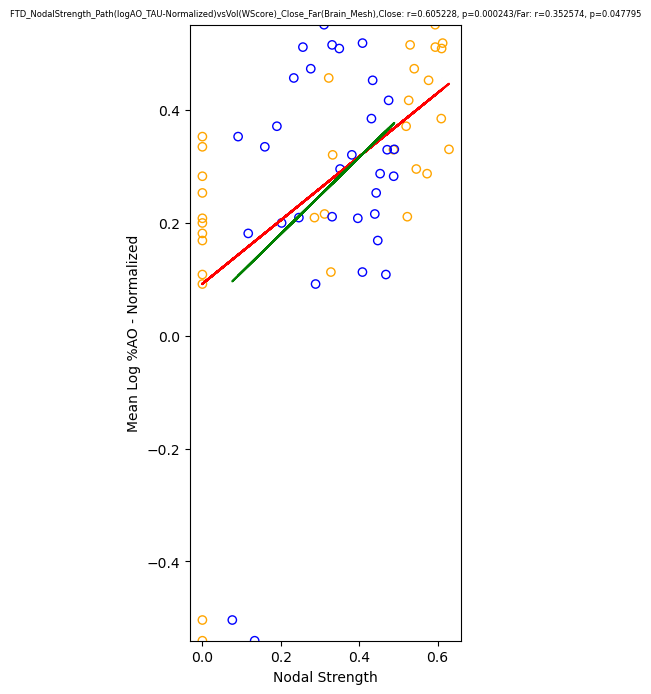

In [32]:
ns.nonZeroDegCorrCloseFar(path_TAU_Drop_Norm, cov_volAtPath_w_dict_Drop["TAU"], 
                       connection_at_path_list_TAU,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)', 
                       linear_regression = True)

AFTER NORMALIZATION: CLOSE & FAR

<Figure size 640x480 with 0 Axes>

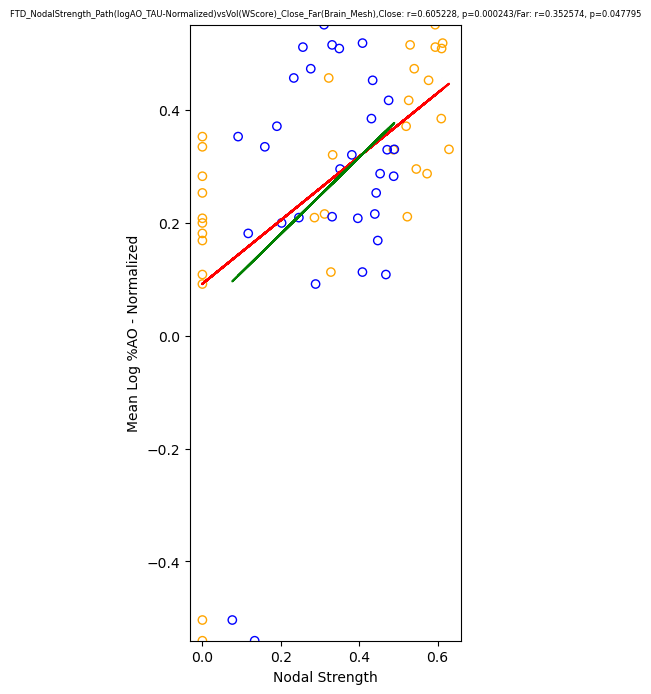

In [33]:
ns.nonZeroDegCorrCloseFar(path_TAU_Drop_Norm, cov_volAtPath_w_dict_Drop["TAU"], 
                       connection_at_path_list_TAU,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)', 
                       linear_regression = True)

In [34]:
covMatX= cov_volAtPath_w_dict_Drop["TAU"]
close_connection_list = connection_at_path_list_TAU

# Copy the Covariance Matrix and set negative values as zero
covMatXnz = covMatX.copy()
covMatXnz[covMatXnz < 0] = 0

# Get sum of covariance values for all regions respective to each region
# Similar to computing the degree of nodes in a Network
degX = np.sum(covMatXnz, axis=0, where=~np.isnan(covMatXnz)) 

# Divide the Covariance Matrix to Close and Far
deg_close_array = []
for i in range(covMatXnz.shape[1]): # For each column in array
    # Get the column
    col = covMatXnz[:, i]

    # Get the Close indices for that col (region)
    close_ind = close_connection_list[i]

    # Get the Degree for Close
    deg_close = np.nansum(col[close_ind])
    deg_close_array.append(deg_close)

# Convert Deg Close to numpy
deg_close = np.array(deg_close_array)

# Get Deg Far
deg_far = degX - deg_close_array

# Normalize the Degree Sum (Due to difference in number of nodes that is close vs far)
# Get Number of Close/Far Nodes
closeNum = [len(sublist) for sublist in close_connection_list]
farNum = (np.zeros((len(close_connection_list), ), dtype=int) + len(close_connection_list)) - closeNum

deg_close_before = deg_close
deg_far_before = deg_far

deg_close = deg_close/closeNum
deg_far = deg_far/farNum

deg_close_after = deg_close
deg_far_after = deg_far

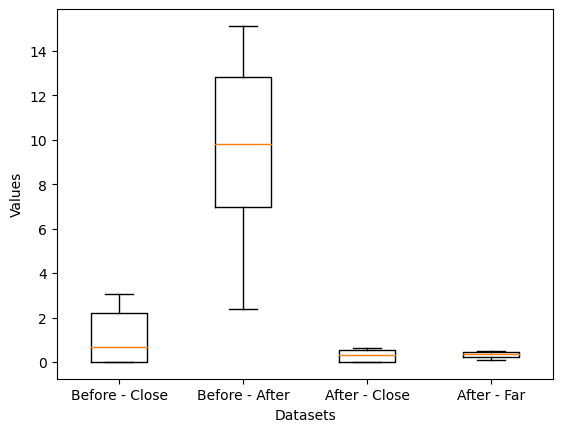

In [35]:
# Create a boxplot for the two arrays
plt.boxplot([deg_close_before, deg_far_before, deg_close_after, deg_far_after], labels=['Before - Close', 'Before - After',
                                                                                        'After - Close', 'After - Far'])

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Values')

# Display the plot
plt.show()

### TAU (2-Connection)

In [46]:
connection_at_path_list_TAU_2 = strongConnection_adjMat(pathToAtlasIndex_list_TAU, thick_adj_matrix_2)

<Figure size 640x480 with 0 Axes>

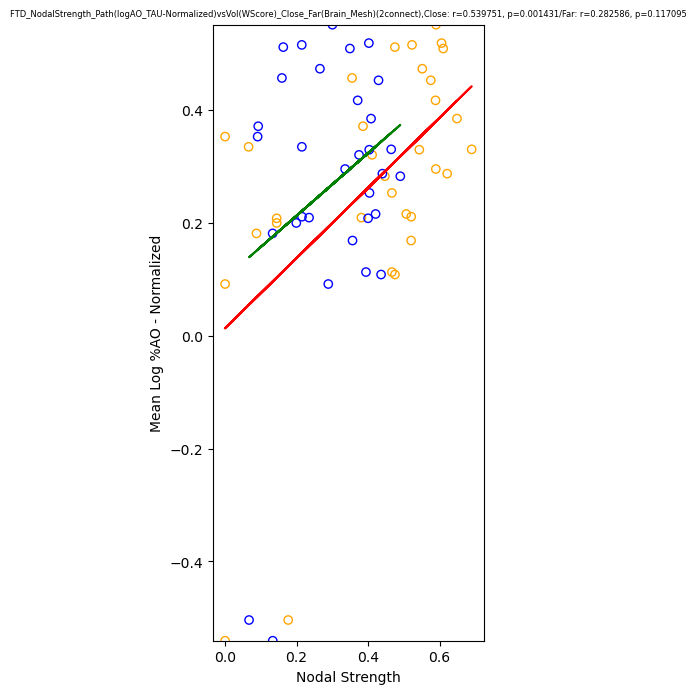

In [47]:
ns.nonZeroDegCorrCloseFar(path_TAU_Drop_Norm, cov_volAtPath_w_dict_Drop["TAU"], 
                       connection_at_path_list_TAU_2,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(2connect)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(2connect)', 
                       linear_regression = True)

### TAU (3-Connection)

In [65]:
connection_at_path_list_TAU_3 = strongConnection_adjMat(pathToAtlasIndex_list_TAU, thick_adj_matrix_3)

<Figure size 640x480 with 0 Axes>

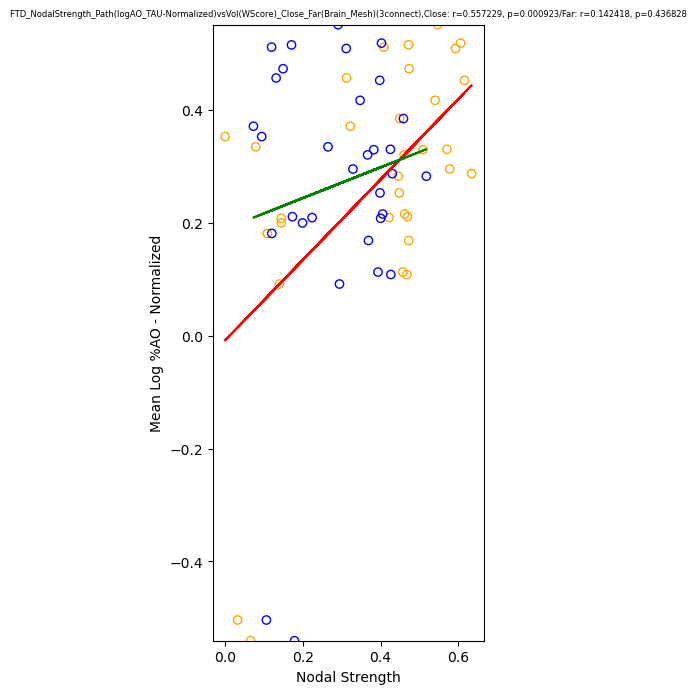

In [66]:
ns.nonZeroDegCorrCloseFar(path_TAU_Drop_Norm, cov_volAtPath_w_dict_Drop["TAU"], 
                       connection_at_path_list_TAU_3,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(3connect)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(3connect)', 
                       linear_regression = True)

### TAU (4-Connection)

In [75]:
connection_at_path_list_TAU_4 = strongConnection_adjMat(pathToAtlasIndex_list_TAU, thick_adj_matrix_4)

<Figure size 640x480 with 0 Axes>

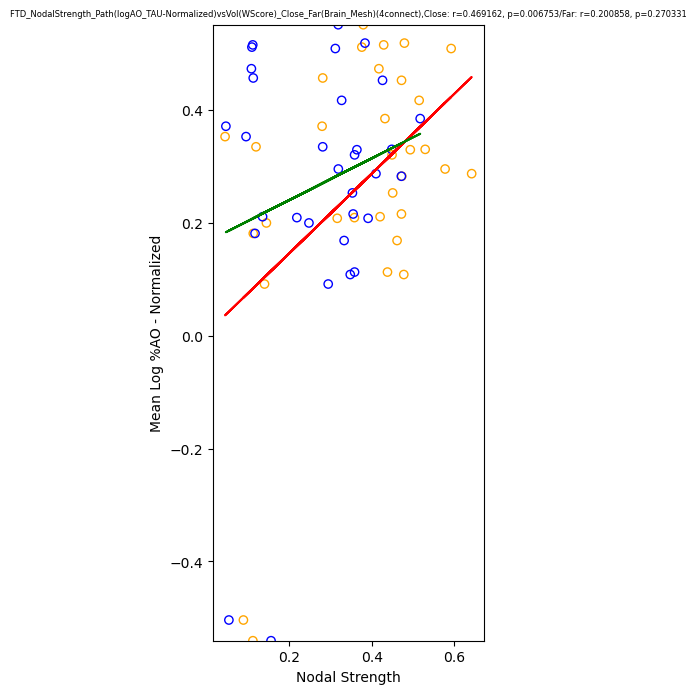

In [76]:
ns.nonZeroDegCorrCloseFar(path_TAU_Drop_Norm, cov_volAtPath_w_dict_Drop["TAU"], 
                       connection_at_path_list_TAU_4,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(4connect)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(4connect)', 
                       linear_regression = True)

### TAU (5-Connection)

In [77]:
connection_at_path_list_TAU_5 = strongConnection_adjMat(pathToAtlasIndex_list_TAU, thick_adj_matrix_5)

<Figure size 640x480 with 0 Axes>

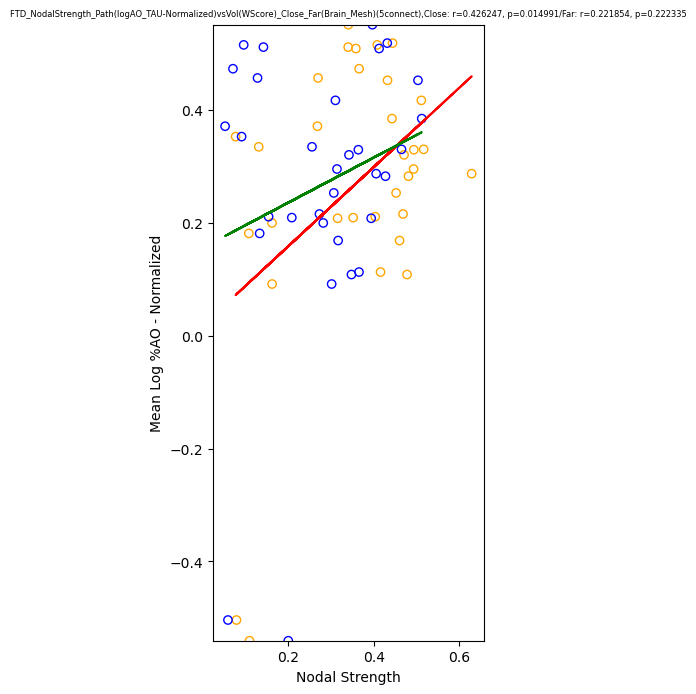

In [78]:
ns.nonZeroDegCorrCloseFar(path_TAU_Drop_Norm, cov_volAtPath_w_dict_Drop["TAU"], 
                       connection_at_path_list_TAU_5,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(5connect)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TAU-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(5connect)', 
                       linear_regression = True)

In [79]:
connection_at_path_list_TAU_5

[array([ 0,  1,  7,  8, 12]),
 array([ 0,  1,  2,  3,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([ 1,  2,  3,  6,  7,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 22, 23,
        24, 25, 26, 27, 28, 29, 30, 31]),
 array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 17, 18, 22,
        23, 25, 26, 27, 28, 30, 31]),
 array([ 3,  4,  5,  7,  8, 10, 11, 13, 14]),
 array([ 1,  3,  4,  5,  6,  7,  8, 10, 11, 13, 14]),
 array([ 1,  2,  3,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 14, 15, 17, 18, 22,
        23, 25, 26, 27, 28, 30, 31]),
 array([ 0,  4,  5,  8,  9, 15]),
 array([ 1,  2,  3,  6,  7,  8,  9, 10, 11, 12, 14, 15, 17, 18, 19, 22, 23,
        24, 25, 26, 27, 28, 29, 30, 31]),
 array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

### TDP (1-Connection)

In [36]:
connection_at_path_list_TDP = strongConnection_adjMat(pathToAtlasIndex_list_TDP, thick_adj_matrix_1)

BEFORE NORMALIZING

<Figure size 640x480 with 0 Axes>

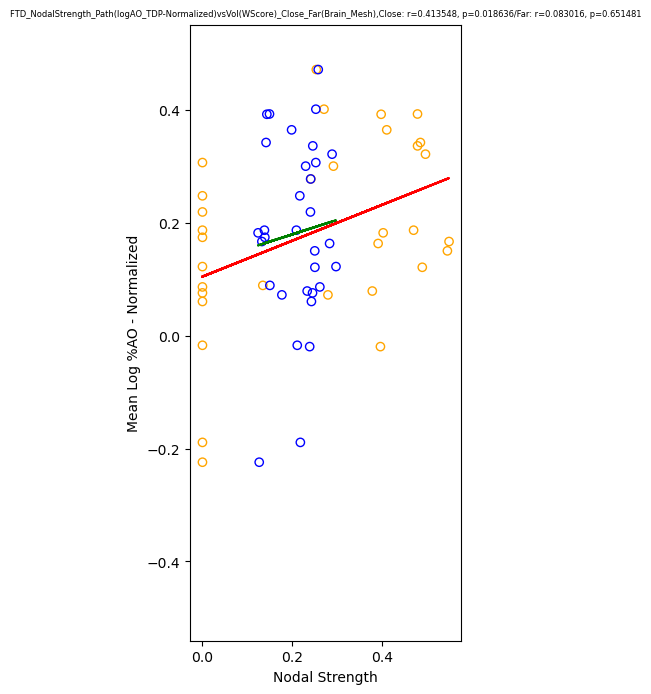

In [37]:
ns.nonZeroDegCorrCloseFar(path_TDP_Drop_Norm, cov_volAtPath_w_dict_Drop["TDP"], 
                       connection_at_path_list_TDP,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)', 
                       linear_regression = True)

AFTER NORMALIZING

<Figure size 640x480 with 0 Axes>

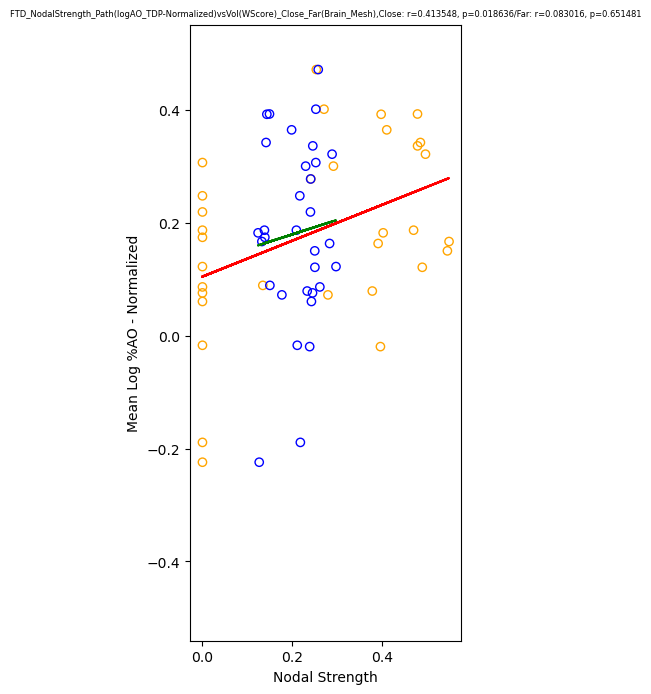

In [38]:
ns.nonZeroDegCorrCloseFar(path_TDP_Drop_Norm, cov_volAtPath_w_dict_Drop["TDP"], 
                       connection_at_path_list_TDP,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)', 
                       linear_regression = True)

In [39]:
covMatX= cov_volAtPath_w_dict_Drop["TDP"]
close_connection_list = connection_at_path_list_TDP

# Copy the Covariance Matrix and set negative values as zero
covMatXnz = covMatX.copy()
covMatXnz[covMatXnz < 0] = 0

# Get sum of covariance values for all regions respective to each region
# Similar to computing the degree of nodes in a Network
degX = np.sum(covMatXnz, axis=0, where=~np.isnan(covMatXnz)) 

# Divide the Covariance Matrix to Close and Far
deg_close_array = []
for i in range(covMatXnz.shape[1]): # For each column in array
    # Get the column
    col = covMatXnz[:, i]

    # Get the Close indices for that col (region)
    close_ind = close_connection_list[i]

    # Get the Degree for Close
    deg_close = np.nansum(col[close_ind])
    deg_close_array.append(deg_close)

# Convert Deg Close to numpy
deg_close = np.array(deg_close_array)

# Get Deg Far
deg_far = degX - deg_close_array

# Normalize the Degree Sum (Due to difference in number of nodes that is close vs far)
# Get Number of Close/Far Nodes
closeNum = [len(sublist) for sublist in close_connection_list]
farNum = (np.zeros((len(close_connection_list), ), dtype=int) + len(close_connection_list)) - closeNum

deg_close_before = deg_close
deg_far_before = deg_far

deg_close = deg_close/closeNum
deg_far = deg_far/farNum

deg_close_after = deg_close
deg_far_after = deg_far

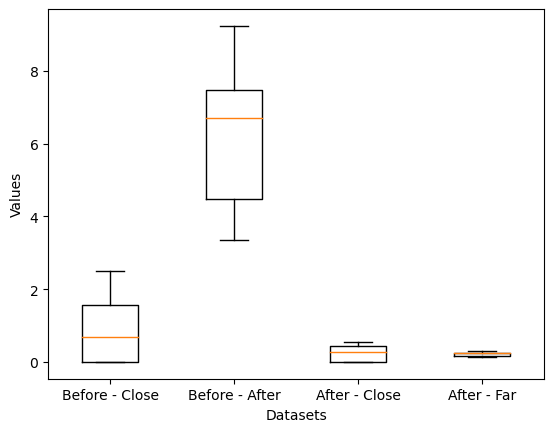

In [40]:
# Create a boxplot for the two arrays
plt.boxplot([deg_close_before, deg_far_before, deg_close_after, deg_far_after], labels=['Before - Close', 'Before - After',
                                                                                        'After - Close', 'After - Far'])

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Values')

# Display the plot
plt.show()

### TDP (2-Connection)

In [48]:
connection_at_path_list_TDP_2 = strongConnection_adjMat(pathToAtlasIndex_list_TDP, thick_adj_matrix_2)

<Figure size 640x480 with 0 Axes>

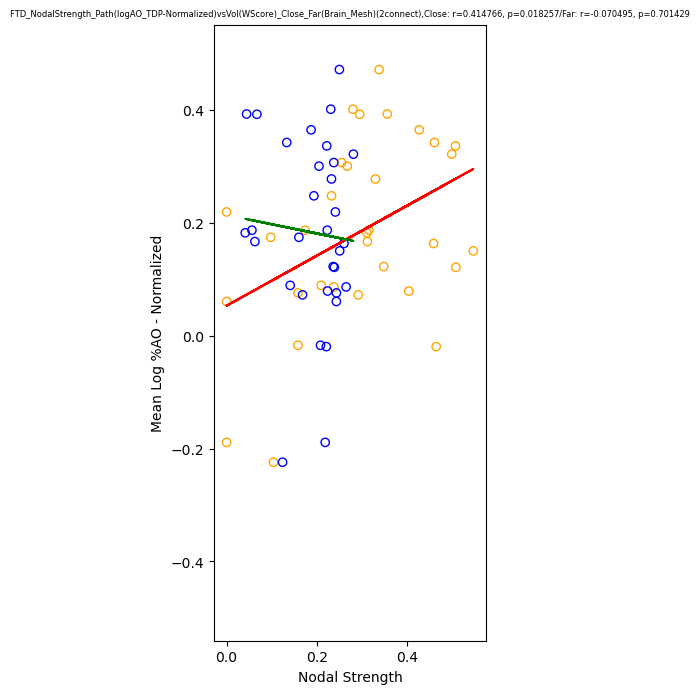

In [49]:
ns.nonZeroDegCorrCloseFar(path_TDP_Drop_Norm, cov_volAtPath_w_dict_Drop["TDP"], 
                       connection_at_path_list_TDP_2,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(2connect)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(2connect)', 
                       linear_regression = True)

### TDP (3-Connection)

In [67]:
connection_at_path_list_TDP_3 = strongConnection_adjMat(pathToAtlasIndex_list_TDP, thick_adj_matrix_3)

<Figure size 640x480 with 0 Axes>

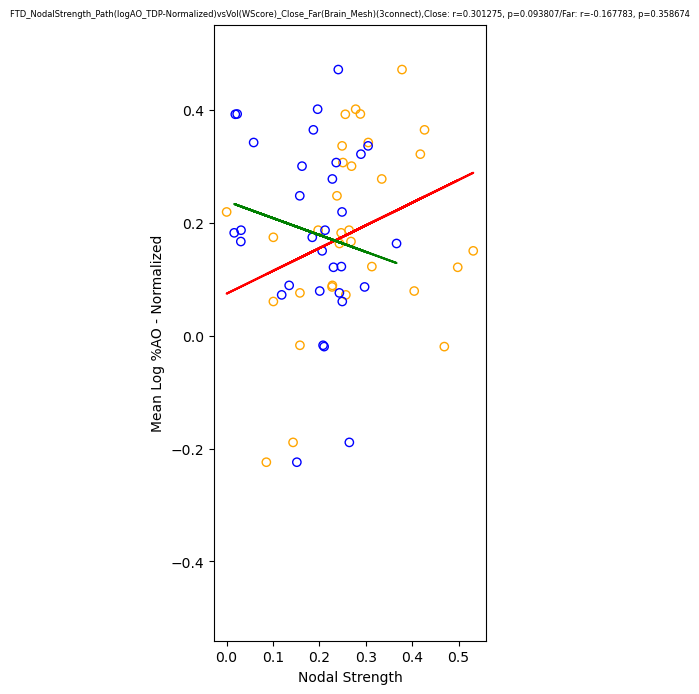

In [68]:
ns.nonZeroDegCorrCloseFar(path_TDP_Drop_Norm, cov_volAtPath_w_dict_Drop["TDP"], 
                       connection_at_path_list_TDP_3,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(3connect)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(3connect)', 
                       linear_regression = True)

### TDP (4-Connection)

In [80]:
connection_at_path_list_TDP_4 = strongConnection_adjMat(pathToAtlasIndex_list_TDP, thick_adj_matrix_4)

<Figure size 640x480 with 0 Axes>

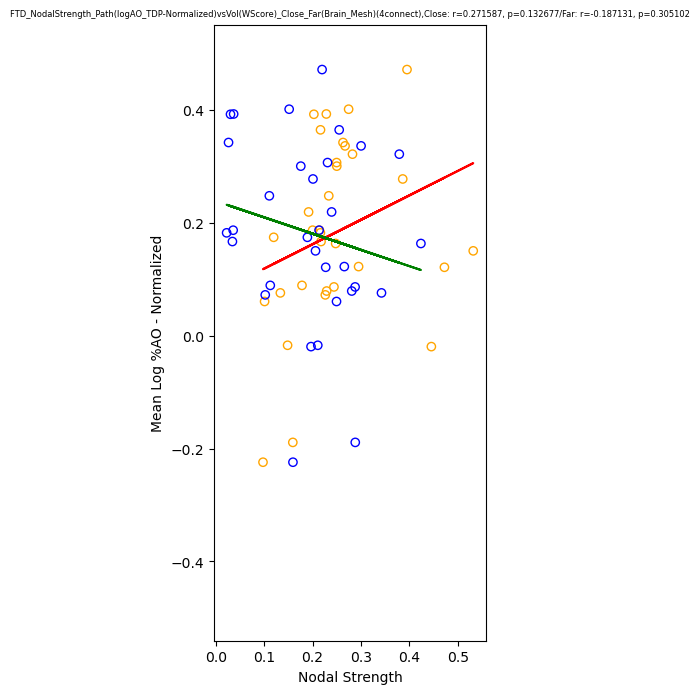

In [81]:
ns.nonZeroDegCorrCloseFar(path_TDP_Drop_Norm, cov_volAtPath_w_dict_Drop["TDP"], 
                       connection_at_path_list_TDP_4,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(4connect)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(4connect)', 
                       linear_regression = True)

### TDP (5-Connection)

In [82]:
connection_at_path_list_TDP_5 = strongConnection_adjMat(pathToAtlasIndex_list_TDP, thick_adj_matrix_5)

<Figure size 640x480 with 0 Axes>

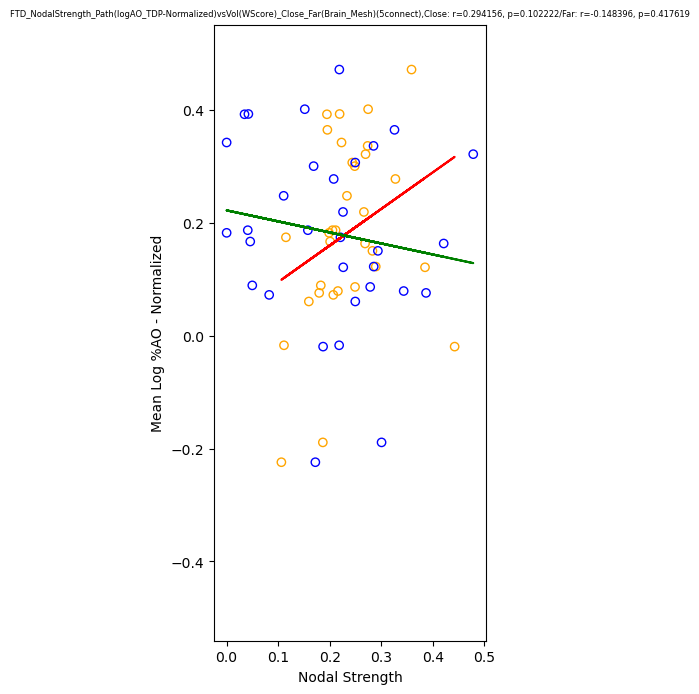

In [83]:
ns.nonZeroDegCorrCloseFar(path_TDP_Drop_Norm, cov_volAtPath_w_dict_Drop["TDP"], 
                       connection_at_path_list_TDP_5,
                       ymin, ymax,
                       'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(5connect)', 
                       'Nodal Strength', 'Mean Log %AO - Normalized', 
                       outputDir = thickAtPath_Fig, 
                       outputName = 'FTD_NodalStrength_Path(logAO_TDP-Normalized)vsVol(WScore)_Close_Far(Brain_Mesh)(5connect)', 
                       linear_regression = True)